In [58]:
import torch 
import torchvision 
import pytorch_lightning as pl 
import numpy as np
import h5py
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from torch.utils.data import  IterableDataset, DataLoader
import random
from torch.utils.data.sampler import WeightedRandomSampler
import math
import torch.nn as nn
import torch.nn.functional as F

from torchmetrics import Accuracy
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger

In [59]:
img = cv2.imread("d:/lab5dataset/Images/train/Angry/0.jpg", cv2.IMREAD_GRAYSCALE)

In [60]:
img = (img/255).astype(np.float32)

In [61]:
img.shape

(48, 48)

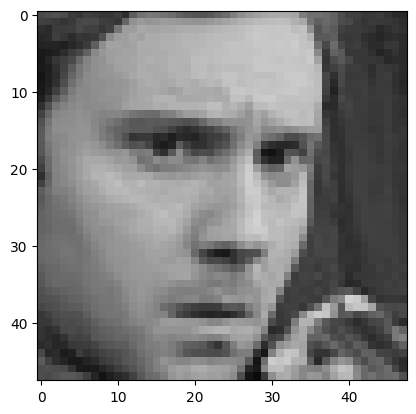

In [62]:
plt.imshow(img, cmap='gray', vmin=0, vmax=1)

In [63]:
class_info = sorted(
            [ d.name for d in os.scandir("D:/lab5dataset/Images/train") if d.is_dir()]
        )

class_info = dict(enumerate(class_info))

In [64]:
class_info

{0: 'Angry',
 1: 'Disgust',
 2: 'Fear',
 3: 'Happy',
 4: 'Neutral',
 5: 'Sad',
 6: 'Surprise'}

In [65]:
class myDataset(IterableDataset):
    def __init__(self, root_dir, shuffle = True):
        super(myDataset).__init__()
        self.root_dir = root_dir
        self.shuffle = shuffle

        self.classes = sorted(
            [d.name for d in os.scandir(root_dir) if d.is_dir()]
        )
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}


    def _get_file_paths(self):
        file_paths = []
        for cls in self.classes:
            cls_dir = os.path.join(self.root_dir, cls)
            for root, _, files in os.walk(cls_dir):
                for file in files:
                    file_paths.append((os.path.join(root, file), cls))

        if self.shuffle:
            random.shuffle(file_paths)

        return file_paths

    

    def __iter__(self):
        file_paths = self._get_file_paths()
        worker_info = torch.utils.data.get_worker_info()
        
        if worker_info is None:  
            iter_start = 0
            iter_end = len(file_paths)
        else:  
            
            per_worker = int(math.ceil(len(file_paths) / float(worker_info.num_workers)))
            worker_id = worker_info.id
            iter_start = worker_id * per_worker
            iter_end = min(iter_start + per_worker, len(file_paths))
        
        for img_path, cls in file_paths[iter_start:iter_end]:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = (img / 255).astype(np.float32)
            label = self.class_to_idx[cls]
            yield img, label

In [66]:
dataset = myDataset("D:/lab5dataset/Images/train")

In [67]:
next(iter(dataset))

(array([[1.        , 1.        , 1.        , ..., 0.99607843, 0.9843137 ,
         0.99607843],
        [1.        , 1.        , 1.        , ..., 0.99607843, 1.        ,
         0.9764706 ],
        [1.        , 1.        , 1.        , ..., 0.99215686, 1.        ,
         0.9882353 ],
        ...,
        [0.25882354, 0.5176471 , 0.85490197, ..., 0.16470589, 0.9019608 ,
         0.9843137 ],
        [0.75686276, 0.80784315, 0.32156864, ..., 0.34509805, 1.        ,
         0.96862745],
        [0.57254905, 0.10588235, 0.01568628, ..., 0.44705883, 0.9607843 ,
         0.96862745]], dtype=float32),
 3)

In [68]:
batch_size = 128

In [69]:
class ImageModule (pl.LightningDataModule):
    def __init__(self, train_dir, val_dir, test_dir, batch_size = batch_size, num_workers = 8):
        super().__init__()
        self.train_dir = train_dir
        self.val_dir = val_dir
        self.test_dir = test_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
    


    def setup(self, stage=None):
        self.train_dataset = myDataset(
            root_dir=self.train_dir,
            shuffle=True
        )

        self.val_dataset = myDataset(
            root_dir=self.val_dir,
            shuffle=False
        )

        self.test_dataset = myDataset(
            root_dir= self.test_dir,
            shuffle=False
        )



    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
            shuffle=False
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
            shuffle=False
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
            shuffle=False
        )


In [70]:
"""


(batch_size, 1, 48,48) -> по 32 ядрам - (batch_size, 32, 48,48)
maxPool c ядром 2 -> (batch_size, 32, 24,24)

дальше аналогично по 64 фичам

и по 128 фичам

итог - (batch_size, 128,6,6)

дальше flatten

классификация = кроссэнтрония


"""

'\n\n\n(batch_size, 1, 48,48) -> по 32 ядрам - (batch_size, 32, 48,48)\nmaxPool c ядром 2 -> (batch_size, 32, 24,24)\n\nдальше аналогично по 64 фичам\n\nи по 128 фичам\n\nитог - (batch_size, 128,6,6)\n\nдальше flatten\n\nклассификация = кроссэнтрония\n\n\n'

In [71]:
class SimpleCNN(pl.LightningModule):
    def __init__(self, num_classes=7, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.learning_rate = learning_rate

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(2),                           

            nn.Conv2d(32, 64, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2),                           

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                            
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 6 * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )


        self.val_acc = Accuracy(task="multiclass", num_classes=7)
        self.train_acc = Accuracy(task='multiclass', num_classes=7)

        self.train_losses = []
        self.val_losses = []
        self.train_metrics = []
        self.val_metrics = []
        

    def forward(self, x):
        x = x.unsqueeze(1)  
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  
        x = self.fc_layers(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.train_acc(logits, y)

        self.train_losses.append(loss.item())
        self.train_metrics.append(acc.item())


        self.log_dict({
            "train/loss" : loss,
            "train/acc" : acc
        }, prog_bar=True)

        print(f"Train_epoch {self.current_epoch}, Iter {batch_idx}, Loss: {loss.item():.4f}, Acc: {acc.item():.4f}")
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.val_acc(logits, y)

        self.val_losses.append(loss.item())
        self.val_metrics.append(acc.item())

        self.log_dict({
            "val/loss" : loss,
            "val/acc" : acc
        }, prog_bar=True)

        print(f"Val_epoch {self.current_epoch}, Iter {batch_idx}, Loss: {loss.item():.4f}, Acc: {acc.item():.4f}")

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        acc = self.test_acc(logits, y)
        self.log("test/acc", acc)
        return logits, y

    def on_validation_epoch_start(self):
        self.val_acc.reset()


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)


In [72]:
datamodule = ImageModule(
    train_dir="D:/lab5dataset/Images/train",
    val_dir="D:/lab5dataset/Images/validation",
    test_dir="D:/lab5dataset/Images/test",
    batch_size=128,
    num_workers=0
)

In [73]:
model = SimpleCNN()

In [74]:
logger = TensorBoardLogger("tb_logs", name="emotion_cnn")

In [75]:
trainer = pl.Trainer(
    max_epochs=201,
    logger=logger,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    log_every_n_steps=10,

)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [76]:
trainer.fit(model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params | Mode 
-----------------------------------------------------------
0 | conv_layers | Sequential         | 92.7 K | train
1 | fc_layers   | Sequential         | 1.2 M  | train
2 | val_acc     | MulticlassAccuracy | 0      | train
3 | train_acc   | MulticlassAccuracy | 0      | train
-----------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.098     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Val_epoch 0, Iter 0, Loss: 1.9097, Acc: 0.0000
Val_epoch 0, Iter 1, Loss: 1.9098, Acc: 0.0000


Training: |          | 0/? [00:00<?, ?it/s]

Train_epoch 0, Iter 0, Loss: 1.9561, Acc: 0.1172
Train_epoch 0, Iter 1, Loss: 1.9026, Acc: 0.1797
Train_epoch 0, Iter 2, Loss: 1.8543, Acc: 0.1484
Train_epoch 0, Iter 3, Loss: 1.7499, Acc: 0.2656
Train_epoch 0, Iter 4, Loss: 1.8505, Acc: 0.3359
Train_epoch 0, Iter 5, Loss: 1.8682, Acc: 0.2656
Train_epoch 0, Iter 6, Loss: 1.8081, Acc: 0.2266
Train_epoch 0, Iter 7, Loss: 1.8531, Acc: 0.1562
Train_epoch 0, Iter 8, Loss: 1.8502, Acc: 0.1406
Train_epoch 0, Iter 9, Loss: 1.8419, Acc: 0.1797
Train_epoch 0, Iter 10, Loss: 1.8428, Acc: 0.2188
Train_epoch 0, Iter 11, Loss: 1.8062, Acc: 0.2656
Train_epoch 0, Iter 12, Loss: 1.8544, Acc: 0.2578
Train_epoch 0, Iter 13, Loss: 1.7698, Acc: 0.2578
Train_epoch 0, Iter 14, Loss: 1.8751, Acc: 0.2109
Train_epoch 0, Iter 15, Loss: 1.9061, Acc: 0.1875



Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, datamodule):
    preds, targets = [], []

    trainer = pl.Trainer(accelerator='gpu' if torch.cuda.is_available() else 'cpu')
    test_loader = datamodule.test_dataloader()
    model.eval()

    with torch.no_grad():
        for x, y in test_loader:
            logits = model(x.cuda() if torch.cuda.is_available() else x)
            preds.extend(logits.argmax(dim=1).cpu().numpy())
            targets.extend(y.cpu().numpy())

    cm = confusion_matrix(targets, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(model.hparams.num_classes))
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(model, datamodule)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


RuntimeError: DataLoader worker (pid(s) 9680, 13492, 13912, 16332, 13272, 14236, 14444, 3800) exited unexpectedly

In [ ]:
trainer.test(model, datamodule=datamodule)


In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("test_logs")
writer.add_scalar("test/val", 42, 0)
writer.close()
